<a href="https://colab.research.google.com/github/asfundyarkhan/dota2-match-prediction/blob/main/dota2_xgboost_prediction_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Dota 2 Match Outcomes with Gradient Boosting

This notebook trains a gradient boosting model (XGBoost) to predict whether the **Radiant** team wins a Dota 2 match, using pre-match / early-game features from the **Dota 2: Predicting Match Outcome** dataset.

We focus on:

- Building a clean ML pipeline
- Evaluating model performance
- Interpreting the model using **feature importance** and **SHAP values**


In [1]:
!pip install xgboost shap --quiet

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.impute import SimpleImputer

import xgboost as xgb
import shap
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [4]:
# If you've uploaded 'train.csv' to the Colab working directory:
DATA_PATH = "/content/train.csv"  # adjust if needed

assert os.path.exists(DATA_PATH), "train.csv not found. Upload it via the Colab file browser."

df = pd.read_csv(DATA_PATH)
df.head()


/tmp/ipython-input-1974101482.py:6: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,match_id,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,...,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win
0,1956782143,106,3,2060,1864,28,0,7,6,8,...,144.0,-71.0,184.0,2.0,2.0,2.0,1.0,32.0,4001.0,True
1,1956782359,112,0,747,1117,0,0,8,13,50,...,135.0,-81.0,294.0,7.0,1.0,3.0,0.0,-24.0,2628.0,True
2,1956782465,46,2,1839,1477,13,1,0,10,6,...,48.0,-72.0,219.0,4.0,2.0,2.0,0.0,-20.0,1721.0,True
3,1956782479,35,0,1681,1312,14,1,12,8,75,...,125.0,-87.0,209.0,3.0,5.0,3.0,0.0,35.0,1965.0,False
4,1956783553,68,0,445,613,3,0,9,6,107,...,97.0,-84.0,NaN,3.0,3.0,2.0,0.0,-42.0,2522.0,False


In [5]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist()[:50], "...")  # first 50 columns

print("\nTarget distribution (radiant_win):")
print(df['radiant_win'].value_counts(normalize=True))

df.describe().T.head()


Shape: (35646, 103)

Columns:
 ['match_id', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items', 'r2_hero', 'r2_level', 'r2_xp', 'r2_gold', 'r2_lh', 'r2_kills', 'r2_deaths', 'r2_items', 'r3_hero', 'r3_level', 'r3_xp', 'r3_gold', 'r3_lh', 'r3_kills', 'r3_deaths', 'r3_items', 'r4_hero', 'r4_level', 'r4_xp', 'r4_gold', 'r4_lh', 'r4_kills', 'r4_deaths', 'r4_items', 'r5_hero', 'r5_level', 'r5_xp', 'r5_gold', 'r5_lh', 'r5_kills', 'r5_deaths', 'r5_items', 'd1_hero', 'd1_level', 'd1_xp', 'd1_gold', 'd1_lh', 'd1_kills', 'd1_deaths', 'd1_items', 'd2_hero'] ...

Target distribution (radiant_win):
radiant_win
True     0.51682
False    0.48318
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
match_id,35646.0,1.958794e+09,1.074237e+06,1.956782e+09,1.957814e+09,1.958867e+09,1.959812e+09,1.960492e+09
r1_hero,35646.0,5.084562e+01,3.306474e+01,1.000000e+00,2.100000e+01,4.800000e+01,7.500000e+01,1.120000e+02
r1_level,35646.0,6.523874e-01,7.937498e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00
r1_xp,35646.0,1.268558e+03,5.066970e+02,0.000000e+00,8.930000e+02,1.184000e+03,1.655000e+03,3.356000e+03
r1_gold,35646.0,1.148770e+03,4.288611e+02,5.600000e+01,8.180000e+02,1.104000e+03,1.419000e+03,4.616000e+03


5. Define target and features

We’ll:

Use radiant_win as y

Drop non-predictive IDs like match_id, match_seq_num if present

Use all remaining numeric features as X



In [6]:
TARGET_COLUMN = "radiant_win"

# Columns that are clearly identifiers / not useful for prediction
columns_to_drop = []
for col in ['match_id', 'match_seq_num', 'start_time']:
    if col in df.columns:
        columns_to_drop.append(col)

print("Dropping columns:", columns_to_drop)

X = df.drop(columns=[TARGET_COLUMN] + columns_to_drop)
y = df[TARGET_COLUMN]

# If target is boolean, convert to 0/1
if y.dtype == bool or y.dtype == 'bool':
    y = y.astype(int)

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Dropping columns: ['match_id']
Features shape: (35646, 101)
Target shape: (35646,)


6. Train / validation split

In [11]:
X_clean = X[y.notna()]
y_clean = y[y.notna()]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_clean
)

X_train.shape, X_valid.shape

((28514, 101), (7129, 101))

7. Handle missing values

We’ll keep it simple: median imputation for all features.

In [12]:
imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train)
X_valid_imp = imputer.transform(X_valid)

print("After imputation:", X_train_imp.shape, X_valid_imp.shape)


After imputation: (28514, 101) (7129, 101)


8. Train an XGBoost classifier

A good, not-too-slow config for this dataset:

In [14]:
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    tree_method="hist"  # fast on CPU in Colab
)

xgb_model.fit(
    X_train_imp, y_train,
    eval_set=[(X_train_imp, y_train), (X_valid_imp, y_valid)],
    verbose=50
)


[0]	validation_0-logloss:0.67023	validation_1-logloss:0.67167
[50]	validation_0-logloss:0.30659	validation_1-logloss:0.34275
[100]	validation_0-logloss:0.23936	validation_1-logloss:0.30073
[150]	validation_0-logloss:0.20666	validation_1-logloss:0.29018
[200]	validation_0-logloss:0.18437	validation_1-logloss:0.28539
[250]	validation_0-logloss:0.16645	validation_1-logloss:0.28322
[300]	validation_0-logloss:0.15022	validation_1-logloss:0.28212
[350]	validation_0-logloss:0.13655	validation_1-logloss:0.28169
[399]	validation_0-logloss:0.12487	validation_1-logloss:0.28095


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

9. Evaluate the model

In [17]:
# Predict probabilities & classes
y_valid_proba = xgb_model.predict_proba(X_valid_imp)[:, 1]
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

# Ensure y_valid is of integer type to match y_valid_pred
y_valid_int = y_valid.astype(int)

acc = accuracy_score(y_valid_int, y_valid_pred)
auc = roc_auc_score(y_valid_int, y_valid_proba)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation ROC-AUC:  {auc:.4f}\n")

print("Classification report:")
print(classification_report(y_valid_int, y_valid_pred))

Validation Accuracy: 0.8690
Validation ROC-AUC:  0.9509

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3445
           1       0.87      0.87      0.87      3684

    accuracy                           0.87      7129
   macro avg       0.87      0.87      0.87      7129
weighted avg       0.87      0.87      0.87      7129



10. Confusion matrix

In [19]:
cm = confusion_matrix(y_valid_int, y_valid_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

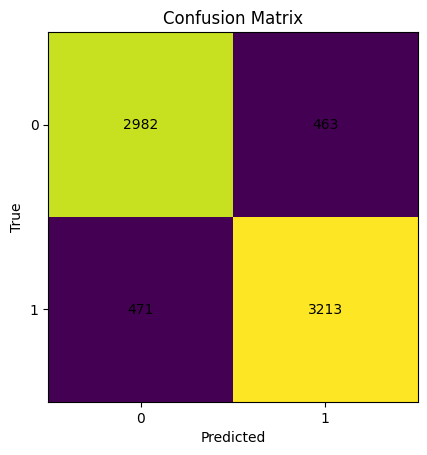

In [20]:
fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')

plt.show()


11. Feature importance (global view)

In [21]:
# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns

# Put into a DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(20)


,feature,importance
30,r4_deaths,0.053840
14,r2_deaths,0.048735
38,r5_deaths,0.046711
54,d2_deaths,0.044923
70,d4_deaths,0.043510
62,d3_deaths,0.042996
46,d1_deaths,0.042513
22,r3_deaths,0.042237
78,d5_deaths,0.038350
6,r1_deaths,0.036023


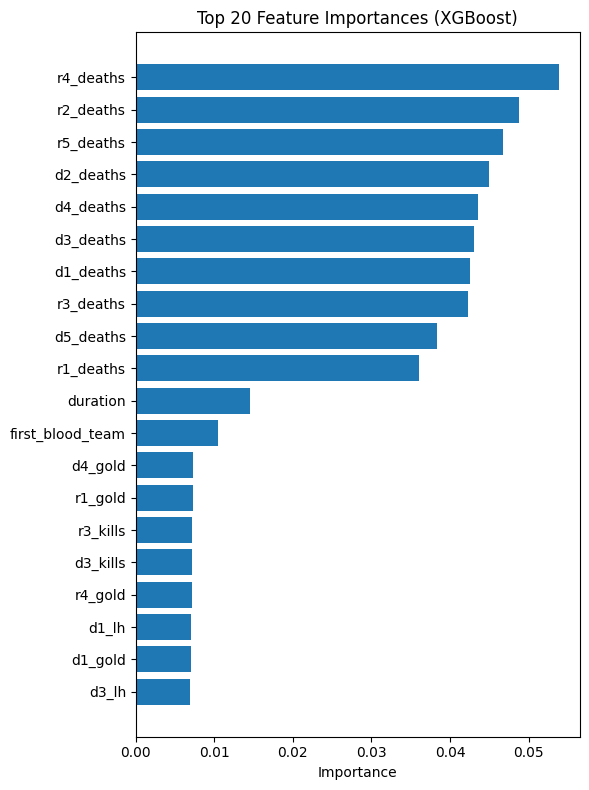

In [22]:
TOP_N = 20
top_fi = fi_df.head(TOP_N).sort_values("importance")

fig, ax = plt.subplots(figsize=(6, 8))
ax.barh(top_fi["feature"], top_fi["importance"])
ax.set_xlabel("Importance")
ax.set_title(f"Top {TOP_N} Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


12. SHAP explainability (global + local)

SHAP (SHapley Additive exPlanations) is a popular framework for explaining model predictions.
GitHub

It can be heavy, so we’ll sample a subset of the validation data.

In [23]:
# Prepare a smaller sample for SHAP (to keep it fast)
shap_sample_size = min(2000, X_valid_imp.shape[0])
sample_idx = np.random.choice(X_valid_imp.shape[0], shap_sample_size, replace=False)

X_shap = X_valid_imp[sample_idx]
y_shap = y_valid.iloc[sample_idx]

# Connect SHAP to our XGBoost model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()


12.1. SHAP summary plot (global importance)

/tmp/ipython-input-2767985702.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, feature_names=feature_names)


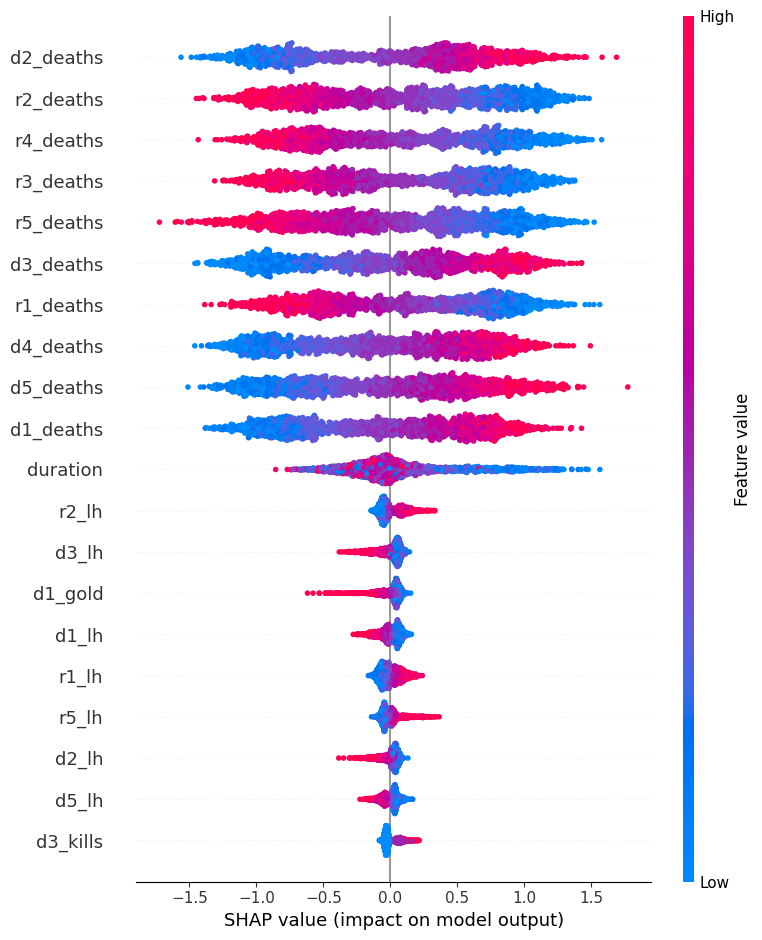

In [24]:
# Summary plot showing feature importance and direction of effect
shap.summary_plot(shap_values, X_shap, feature_names=feature_names)


12.2. SHAP force plot for a single match (local explanation)

In [25]:
# Pick one example match from the SHAP sample
i = 0  # change index to inspect different matches
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_shap[i, :],
    feature_names=feature_names
)


13. Save the trained model (optional, for reuse)

In [26]:
import joblib

MODEL_PATH = "/content/xgb_dota2_radiant_win.pkl"
joblib.dump({
    "model": xgb_model,
    "imputer": imputer,
    "features": feature_names.tolist()
}, MODEL_PATH)

MODEL_PATH


'/content/xgb_dota2_radiant_win.pkl'

14. Optional: simple “what-if” function to use in your tutorial

This is not mandatory, but it makes your tutorial more interactive / creative:

In [27]:
def predict_radiant_win(features_dict):
    """
    features_dict: {feature_name: value, ...}
    Missing features will be filled with training median.
    """
    # Start with 1-row DataFrame of zeros
    row = pd.DataFrame(np.zeros((1, len(feature_names))), columns=feature_names)

    # Set the provided feature values
    for k, v in features_dict.items():
        if k in row.columns:
            row.loc[0, k] = v

    # Impute (using medians learned from training)
    row_imp = imputer.transform(row)

    proba = xgb_model.predict_proba(row_imp)[0, 1]
    return proba

# Example (dummy values, adapt based on real columns in your dataset):
example_features = {
    # "radiant_gold_adv": 2500,
    # "radiant_tower_status": 2047,
    # "dire_tower_status": 1023,
}

if example_features:
    print("Predicted Radiant win probability:", predict_radiant_win(example_features))
else:
    print("Fill example_features with real column names first.")


Fill example_features with real column names first.
